# Steam Store Games EDA Notebook - Versión Ejecutiva

Este notebook está preparado para Google Colab y contiene un análisis completo y profesional del dataset Steam Store Games, listo para presentar a la dirección. Cada sección está en celdas separadas con explicación, gráficos y conclusiones.

## 1. Setup del entorno y librerías
- Instala pandas, numpy, matplotlib, seaborn, bokeh y sklearn si no están presentes.
- Bokeh se usa para gráficos interactivos y matplotlib/seaborn para visualizaciones clásicas.

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import re
try:
    import matplotlib.pyplot as plt
    HAVE_MPL = True
except:
    HAVE_MPL = False
try:
    import seaborn as sns
    HAVE_SEABORN = True
except:
    HAVE_SEABORN = False
try:
    from bokeh.plotting import figure, output_file, save
    HAVE_BOKEH = True
except:
    HAVE_BOKEH = False
try:
    from sklearn.preprocessing import MultiLabelBinarizer
    HAVE_MLB = True
except:
    HAVE_MLB = False

## 2. Carga de datos
Sube `steam.csv` a la carpeta `data/` y asegúrate de que tenga el formato correcto.

In [ ]:
DATA_DIR = Path('data')
CSV_PATH = DATA_DIR / 'steam.csv'
df = pd.read_csv(CSV_PATH, low_memory=False)
print(f'Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas')
df.head()

Dataset cargado: 27075 filas, 18 columnas


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


## 3. Limpieza y preprocesado detallado
- Tratamiento de duplicados y nulos.
- Conversión de fechas y normalización de precios.
- Parseo de owners y campos compuestos (genres, tags, platforms).

In [ ]:
# Limpiar nombres de columna
df.columns = [c.strip() if isinstance(c,str) else c for c in df.columns]

# Parsear fechas
date_col = [c for c in df.columns if 'date' in c.lower()]
if date_col:
    date_col = date_col[0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
else:
    date_col = None

# Preprocesar precios
price_col = [c for c in df.columns if 'price' in c.lower() or 'cost' in c.lower()]
if price_col:
    price_col = price_col[0]
    df[price_col] = df[price_col].astype(str).str.replace('Â','',regex=False)
    df[price_col] = df[price_col].str.replace(r'\$','',regex=True).str.replace(',','')
    df[price_col] = pd.to_numeric(df[price_col].replace('nan', np.nan), errors='coerce')
else:
    price_col = None

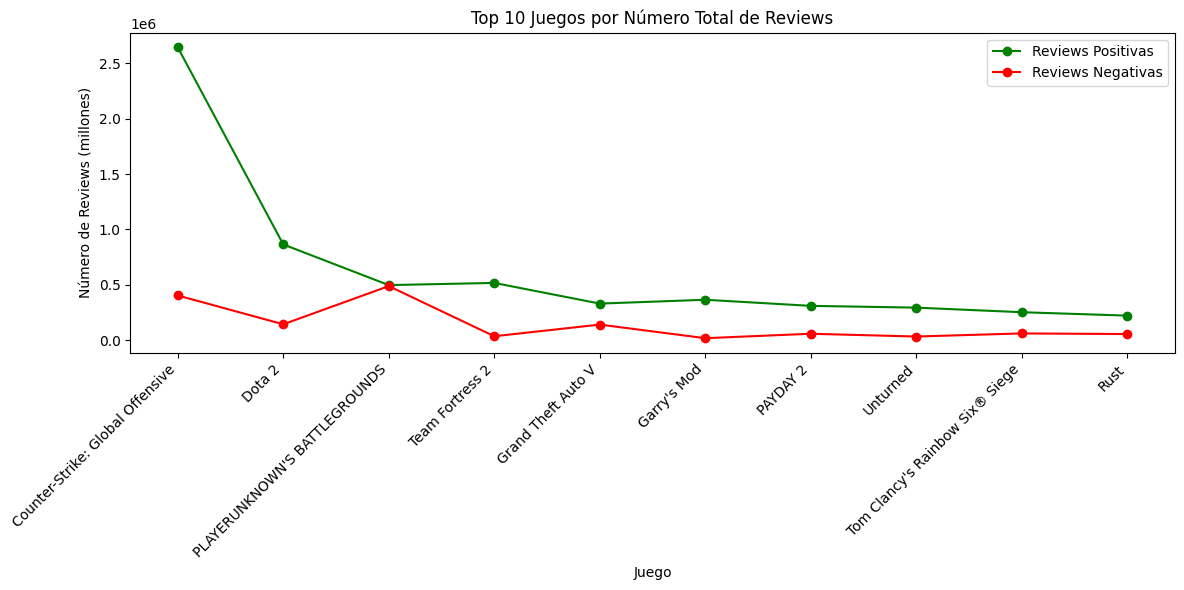

In [ ]:
# Top 10 juegos por total de reviews
if 'positive_ratings' in df.columns and 'negative_ratings' in df.columns:
    df['total_reviews'] = df['positive_ratings'] + df['negative_ratings']

    top10_games = df.sort_values('total_reviews', ascending=False).head(10)

    # Convertir a miles para eje Y
    positive_k = top10_games['positive_ratings']
    negative_k = top10_games['negative_ratings']

    # Preparar gráfico
    plt.figure(figsize=(12,6))
    plt.plot(top10_games['name'], positive_k, marker='o', label='Reviews Positivas', color='green')
    plt.plot(top10_games['name'], negative_k, marker='o', label='Reviews Negativas', color='red')

    plt.ylabel('Número de Reviews (millones)')
    plt.xlabel('Juego')
    plt.title('Top 10 Juegos por Número Total de Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Las columnas 'positive_ratings' o 'negative_ratings' no existen en el dataset.")

## Seleccionamos solo las columnas numéricas relevantes (precio y reseñas) para evitar errores en los cálculos estadísticos y simplificar el análisis.
## Esto crea un subconjunto limpio llamado df_num, ideal para cálculos y gráficas.

In [ ]:
numeric_cols = ['price', 'positive_ratings', 'negative_ratings', 'total_reviews']

df_num = df[numeric_cols].dropna()
df_num.head()


,price,positive_ratings,negative_ratings,total_reviews
0,7.19,124534,3339,127873
1,3.99,3318,633,3951
2,3.99,3416,398,3814
3,3.99,1273,267,1540
4,3.99,5250,288,5538


## Generamos un mapa de calor para visualizar cómo se relacionan numéricamente las variables entre sí.
## Esto permite detectar si una variable explica a otra (por ejemplo, más reviews positivas → más reviews negativas).

## El heatmap muestra cómo se relacionan las variables:

Valores cercanos a 1 → correlación positiva fuerte

Cercanos a -1 → correlación negativa

Cercanos a 0 → relación débil


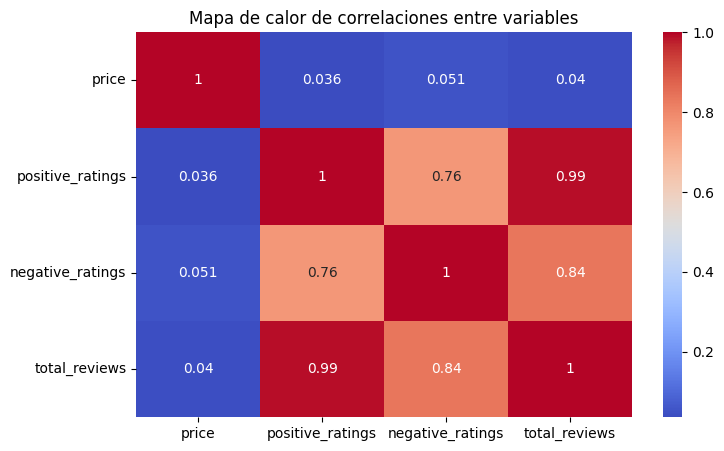

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.title("Mapa de calor de correlaciones entre variables")
plt.show()








## Hacemos un histograma con KDE para observar la distribución de precios, y analizar la mayoria de los prescios que existen si son caros o baratos


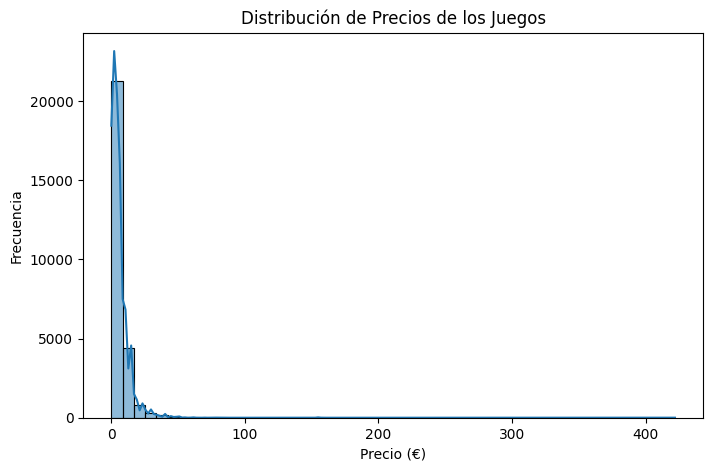

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'].dropna(), bins=50, kde=True)
plt.title("Distribución de Precios de los Juegos")
plt.xlabel("Precio (€)")
plt.ylabel("Frecuencia")
plt.show()


## Calculamos la media y desviación estándar del precio para superponer una curva normal teórica.
## Esto nos permite ver si la distribución real sigue una forma normal o está sesgada.

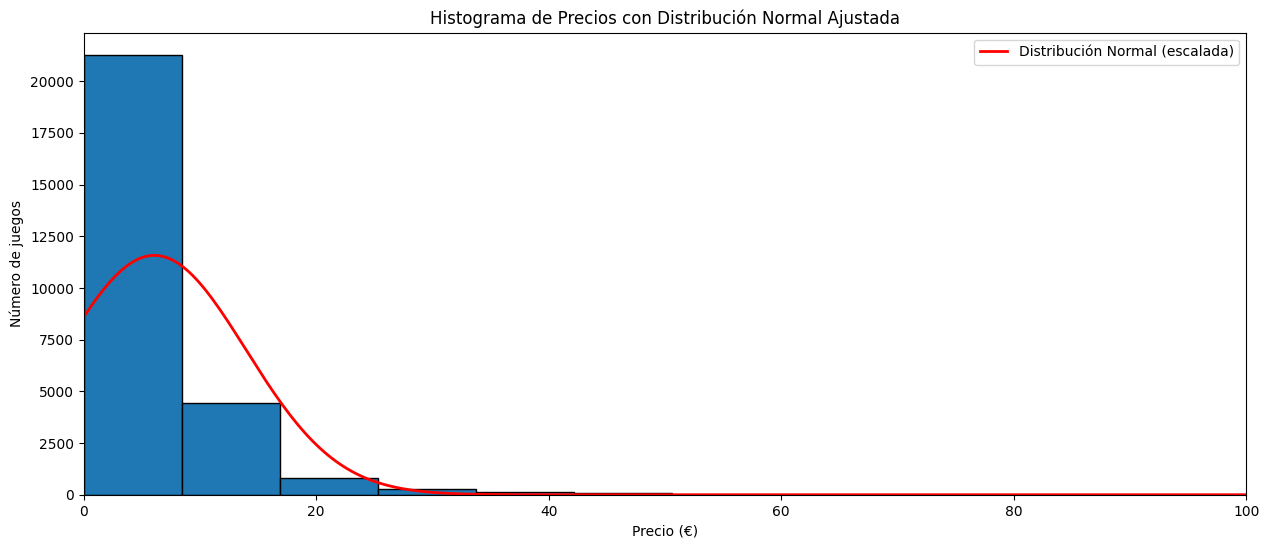

In [ ]:
import scipy.stats as stats

x = df['price'].dropna()
mu, sigma = x.mean(), x.std()

plt.figure(figsize=(15,6))

# Histograma en frecuencia real
counts, bins, patches = plt.hist(x, bins=50, edgecolor='black')

# Rango del eje X
plt.xlim(0, 100)

# Cálculo de la curva normal escalada al histograma
bin_width = bins[1] - bins[0]           # anchura de cada barra
scale_factor = len(x) * bin_width        # para que coincida con las frecuencias

xs = np.linspace(0, 100, 300)
normal_curve = stats.norm.pdf(xs, mu, sigma) * scale_factor

plt.plot(xs, normal_curve, color='red', linewidth=2, label="Distribución Normal (escalada)")

plt.title("Histograma de Precios con Distribución Normal Ajustada")
plt.xlabel("Precio (€)")
plt.ylabel("Número de juegos")
plt.legend()
plt.show()


## Como podemos ver esos outliers, según nuestra investigación se debe a ediciones especiales de Steam por eso aparecen como ven en la siguiente gráfica.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


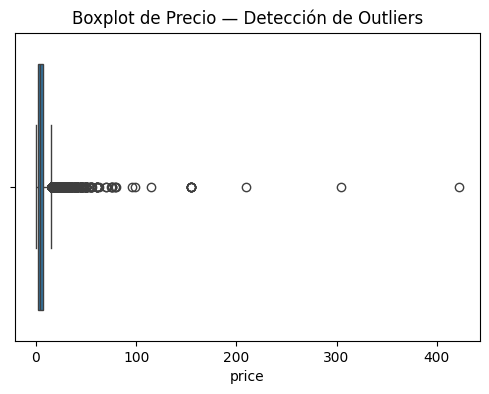

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['price'])
plt.title("Boxplot de Precio — Detección de Outliers")
plt.show()


## Creo tres distribuciones artificiales para visualizar el concepto de sesgo:
## negativo, simétrico y positivo.
## Esto ayuda a interpretar si el precio o reviews de Steam presentan sesgo real. revisar

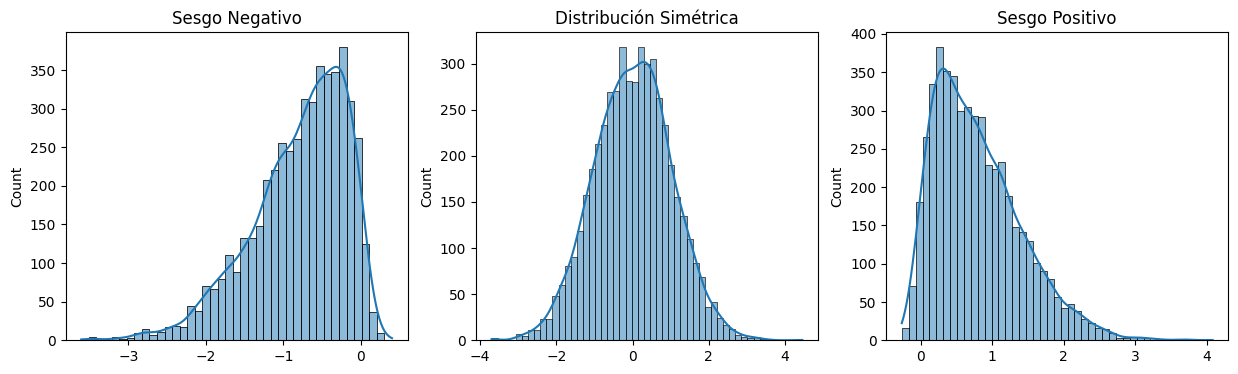

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

sns.histplot(stats.skewnorm.rvs(-8, size=5000), kde=True, ax=ax[0])
ax[0].set_title("Sesgo Negativo")

sns.histplot(np.random.normal(0,1,5000), kde=True, ax=ax[1])
ax[1].set_title("Distribución Simétrica")

sns.histplot(stats.skewnorm.rvs(8, size=5000), kde=True, ax=ax[2])
ax[2].set_title("Sesgo Positivo")

plt.show()



## La PMF muestra la probabilidad exacta de cada valor discreto.
## En este caso, vemos qué edades requeridas son más frecuentes en los juegos de Steam.
## Sirve para entender cómo se distribuyen categorías discretas.

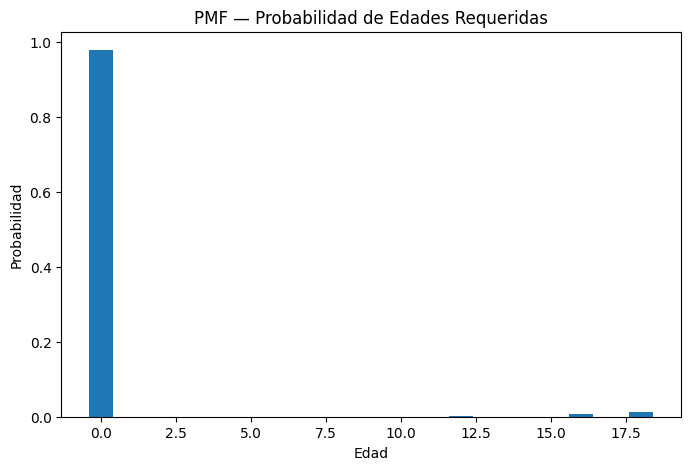

In [ ]:
if 'required_age' in df.columns:
    pmf = df['required_age'].value_counts(normalize=True).sort_index()

    plt.figure(figsize=(8,5))
    plt.bar(pmf.index, pmf.values)
    plt.title("PMF — Probabilidad de Edades Requeridas")
    plt.xlabel("Edad")
    plt.ylabel("Probabilidad")
    plt.show()


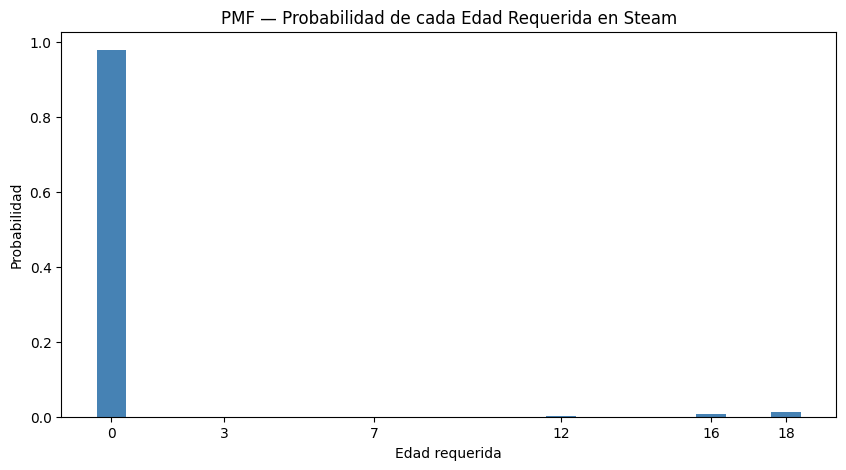

In [ ]:
# Asegurar que la columna existe y convertir a numérica
if 'required_age' in df.columns:
    df['required_age'] = pd.to_numeric(df['required_age'], errors='coerce')

    # Tabla de probabilidades por edad
    pmf = (
        df['required_age']
        .value_counts(normalize=True)
        .sort_index()
    )

    plt.figure(figsize=(10,5))
    plt.bar(pmf.index, pmf.values, color="steelblue")
    plt.title("PMF — Probabilidad de cada Edad Requerida en Steam")
    plt.xlabel("Edad requerida")
    plt.ylabel("Probabilidad")
    plt.xticks(pmf.index)   # muestra cada edad exacta en el eje X
    plt.show()
else:
    print("La columna 'required_age' no se encuentra en el dataset.")

## La PDF es una versión suavizada del histograma.
## Nos muestra dónde se concentran más los precios y la forma general de su distribución.
## Permite ver picos, colas y densidades sin el ruido del histograma.

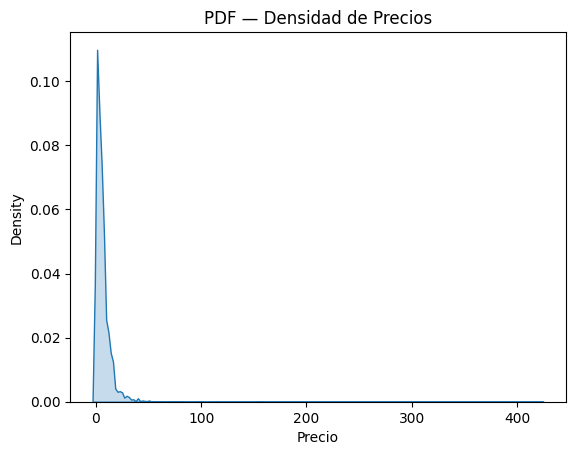

In [ ]:
sns.kdeplot(df['price'].dropna(), fill=True)
plt.title("PDF — Densidad de Precios")
plt.xlabel("Precio")
plt.show()


## La CDF indica qué porcentaje de los juegos tiene un precio menor o igual a un valor X.
## Ayuda a entender rápidamente cómo se acumulan los precios y en qué rangos está la mayoría.

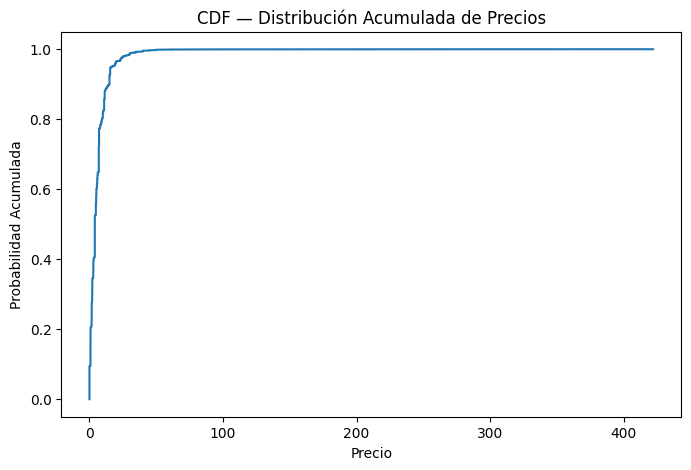

In [ ]:
x = np.sort(df['price'].dropna())
y = np.arange(1, len(x)+1) / len(x)

plt.figure(figsize=(8,5))
plt.plot(x, y)
plt.title("CDF — Distribución Acumulada de Precios")
plt.xlabel("Precio")
plt.ylabel("Probabilidad Acumulada")
plt.show()


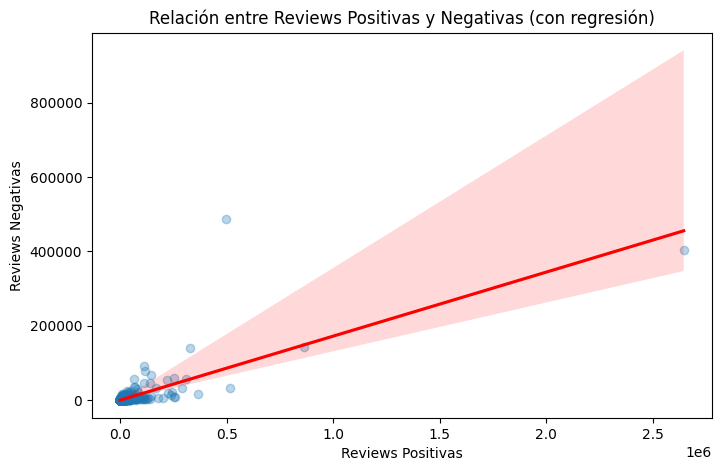

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x='positive_ratings', y='negative_ratings',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Relación entre Reviews Positivas y Negativas (con regresión)")
plt.xlabel("Reviews Positivas")
plt.ylabel("Reviews Negativas")
plt.show()


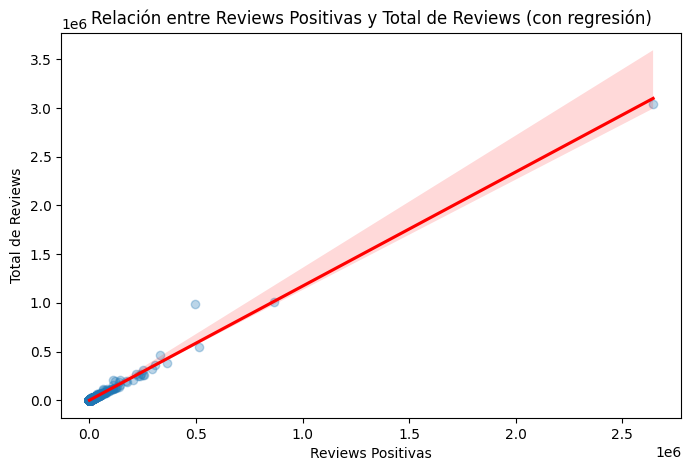

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x='positive_ratings', y='total_reviews',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Relación entre Reviews Positivas y Total de Reviews (con regresión)")
plt.xlabel("Reviews Positivas")
plt.ylabel("Total de Reviews")
plt.show()


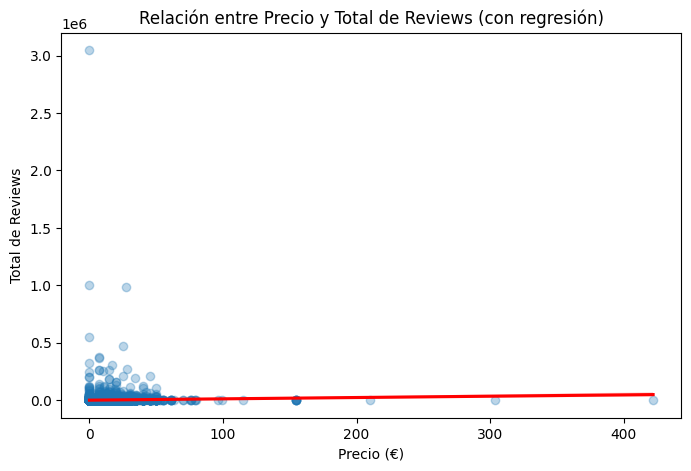

In [ ]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x='price', y='total_reviews',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Relación entre Precio y Total de Reviews (con regresión)")
plt.xlabel("Precio (€)")
plt.ylabel("Total de Reviews")
plt.show()


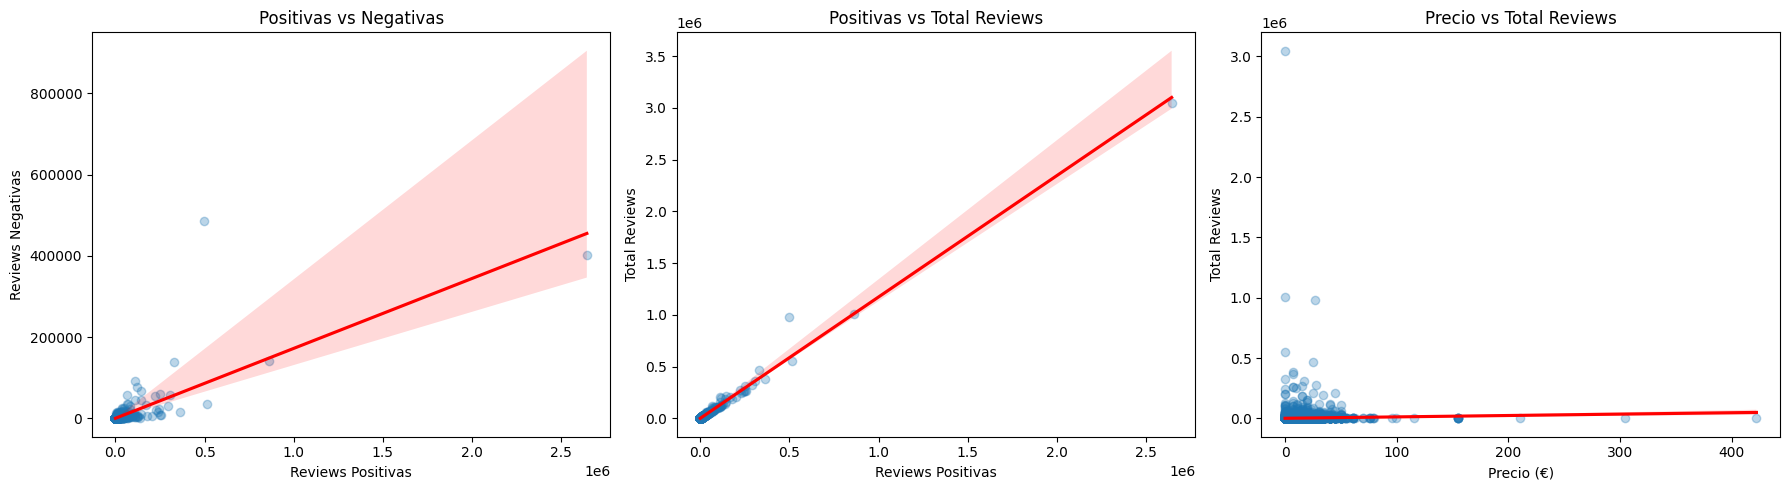

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))

# 1. positive_ratings vs negative_ratings
sns.regplot(data=df, x='positive_ratings', y='negative_ratings',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axs[0])
axs[0].set_title("Positivas vs Negativas")
axs[0].set_xlabel("Reviews Positivas")
axs[0].set_ylabel("Reviews Negativas")

# 2. positive_ratings vs total_reviews
sns.regplot(data=df, x='positive_ratings', y='total_reviews',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axs[1])
axs[1].set_title("Positivas vs Total Reviews")
axs[1].set_xlabel("Reviews Positivas")
axs[1].set_ylabel("Total Reviews")

# 3. price vs total_reviews
sns.regplot(data=df, x='price', y='total_reviews',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axs[2])
axs[2].set_title("Precio vs Total Reviews")
axs[2].set_xlabel("Precio (€)")
axs[2].set_ylabel("Total Reviews")

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

X = df['positive_ratings']
y = df['total_reviews']

X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()

# ----- RESULTADOS -----
params = modelo.params
conf_int = modelo.conf_int()

print("📌 REGRESIÓN LINEAL SIMPLE")
print("Ecuación:")
print(f"total_reviews = {params['const']:.3f} + {params['positive_ratings']:.6f} * positive_ratings")

print("\n📊 MÉTRICAS:")
print(f"R² = {modelo.rsquared:.3f}  ({modelo.rsquared*100:.1f}%)")
print(f"p-valor pendiente = {modelo.pvalues['positive_ratings']:.6f}")
print(f"IC95% pendiente = [{conf_int.loc['positive_ratings',0]:.6f}, {conf_int.loc['positive_ratings',1]:.6f}]")

print("\n🧠 INTERPRETACIÓN:")
print(f"A mas reviews positivas, mas reviews totales.")
print(f"Significativo: {'Sí' if modelo.pvalues['positive_ratings'] < 0.05 else 'No'}")


📌 REGRESIÓN LINEAL SIMPLE
Ecuación:
total_reviews = 38.799 + 1.172132 * positive_ratings

📊 MÉTRICAS:
R² = 0.985  (98.5%)
p-valor pendiente = 0.000000
IC95% pendiente = [1.170394, 1.173870]

🧠 INTERPRETACIÓN:
A mas reviews positivas, mas reviews totales.
Significativo: Sí


In [ ]:
from scipy.stats import pearsonr
import numpy as np

# Create 'rating_ratio' column
# Ensure total_reviews is not zero before division
df['rating_ratio'] = df.apply(
    lambda row: row['positive_ratings'] / row['total_reviews'] if row['total_reviews'] > 0 else np.nan,
    axis=1
)

# Create 'owners_avg' column by parsing the 'owners' string
def parse_owners(owners_str):
    if pd.isna(owners_str):
        return np.nan

    # Remove commas for easier conversion
    owners_str = owners_str.replace(',', '')

    parts = owners_str.split('-')
    if len(parts) == 2:
        try:
            lower = int(parts[0])
            upper = int(parts[1])
            return (lower + upper) / 2
        except ValueError:
            return np.nan # Handle cases where conversion to int fails
    elif len(parts) == 1: # Handle cases like '100000' (single value, if any)
        try:
            return int(parts[0])
        except ValueError:
            return np.nan
    return np.nan # Default for unhandled formats

df['owners_avg'] = df['owners'].apply(parse_owners)

# Limpiar datos
df_test = df[['rating_ratio', 'owners_avg']].dropna()

# Test de correlación
corr, p_value = pearsonr(df_test['rating_ratio'], df_test['owners_avg'])

print(f"Correlación Pearson: {corr:.3f}")
print(f"p-value: {p_value:.5f}")

if p_value < 0.05:
    print("Se rechaza H₀: existe relación significativa entre valoraciones y owners.")
else:
    print("No se puede rechazar H₀.")

Correlación Pearson: 0.035
p-value: 0.00000
Se rechaza H₀: existe relación significativa entre valoraciones y owners.


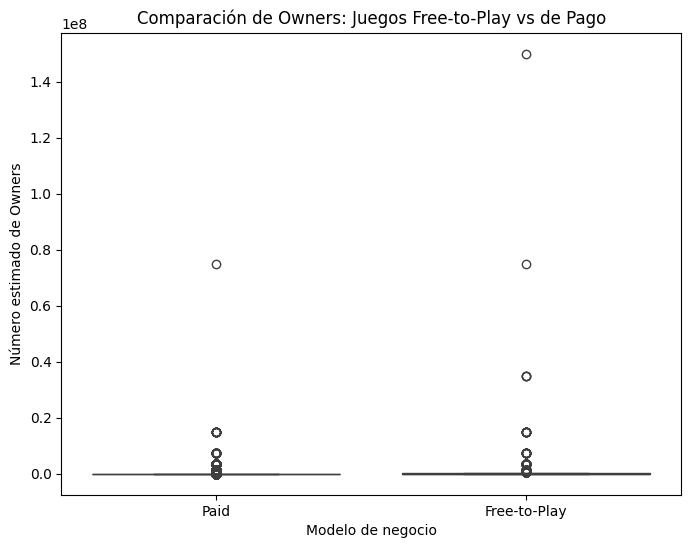

In [ ]:
# Crear variable binaria free vs paid
df['pricing_model'] = df['price'].apply(lambda x: 'Free-to-Play' if x == 0 else 'Paid')

# Filtrar datos válidos
df_box = df[['pricing_model', 'owners_avg']].dropna()

# Boxplot comparativo
plt.figure(figsize=(8,6))
sns.boxplot(x='pricing_model', y='owners_avg', data=df_box)
plt.ylabel('Número estimado de Owners')
plt.xlabel('Modelo de negocio')
plt.title('Comparación de Owners: Juegos Free-to-Play vs de Pago')
plt.show()
